# Calendar and Daily Visualizations

This notebook contains the main body of work of data tranformation, calendar heatmap visualizations, as well as the generation of daily temperature plots. 

# Todo and ideas

#TODO: 
#Weather, system capacity -> indoor temperature/comfort

#Smoothing data:
#Average based on time of day
#Document challenges i.e. breaking down temperature between and inside days

- Drop or hide months with high volatility. Show just heating and cooling season
- Day by day period? Temperature within a day in a season
- Fill space between high/low. 
- Is there ever a day where temperature is out of range on both ends? New column for in high/low temp range. # of hours outside of range within a day.  Regular vs problematic days. Most extreme day in each month?
- Within day: point color coding failed too hot/too cold, size based on # of hours
- Roll for every hour in each day? Can create synthetic day in january 
- Heatmap/tile visualization (think calendar), color code/intensity based on how long out of range/on what end

Make new labels for rows -> can query later
- Week/day num from timestamp for calendar
- Timestamp, middle of each hour. Enables condensed axis etc. 

Look into larger time series i.e. several years


## Cleaning and Data Transformation

In [246]:
# Importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"

In [247]:
# Cleaning off first row and units
def clean_units(df):
    units_list = df.iloc[0]
    df = df.iloc[1:]

    # Cleaning units
    df = df.apply(pd.to_numeric)

    return df, units_list


In [248]:
# Importing Austin dataset as framework
atx_df = pd.read_csv('BEopt Viz\\atx_undersized_new.csv')
atx_df, units = clean_units(atx_df)
assert atx_df.shape[0] == 365*24 #asserting that each row is one hour our of the year
atx_df

C:\Users\micha.DESKTOP-U2HVTMF\AppData\Local\Temp\ipykernel_7884\747913533.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  atx_df = pd.read_csv('BEopt Viz\\atx_undersized_new.csv')


,My Design - Energy Use| Total,My Design - Fuel Use| Electricity: Total,My Design - Fuel Use| Natural Gas: Total,My Design - End Use| Electricity: Heating,My Design - End Use| Electricity: Heating Heat Pump Backup,My Design - End Use| Electricity: Heating Fans/Pumps,My Design - End Use| Electricity: Cooling,My Design - End Use| Electricity: Cooling Fans/Pumps,My Design - End Use| Electricity: Lighting Interior,My Design - End Use| Electricity: Lighting Exterior,...,My Design - Temperature| Cooling Setpoint,My Design - Airflow| Infiltration,My Design - Airflow| Mechanical Ventilation,My Design - Airflow| Natural Ventilation,My Design - Weather| Drybulb Temperature,My Design - Weather| Wetbulb Temperature,My Design - Weather| Relative Humidity,My Design - Weather| Wind Speed,My Design - Weather| Diffuse Solar Radiation,My Design - Weather| Direct Solar Radiation
1,4.12,1.21,0.00,0.74,0.0,0.02,0.00,0.00,0.06,0.02,...,74,30.12,66.48,0.0,42.98,42.19,94,0.00,0.0,0.0
2,4.15,1.21,0.00,0.78,0.0,0.03,0.00,0.00,0.05,0.02,...,74,29.13,66.07,0.0,44.06,43.38,95,1.34,0.0,0.0
3,4.18,1.22,0.00,0.81,0.0,0.03,0.00,0.00,0.05,0.02,...,74,28.90,65.87,0.0,44.96,44.41,96,4.70,0.0,0.0
4,5.61,1.22,1.45,0.82,0.0,0.03,0.00,0.00,0.05,0.01,...,74,29.88,65.67,0.0,46.04,44.62,90,8.05,0.0,0.0
5,4.22,1.24,0.00,0.81,0.0,0.03,0.00,0.00,0.05,0.01,...,74,33.13,65.87,0.0,46.94,44.46,83,11.63,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,6.98,1.61,1.49,0.00,0.0,0.00,0.32,0.09,0.50,0.03,...,74,21.68,70.58,0.0,69.08,64.37,78,14.99,0.0,0.0
8757,6.56,1.49,1.49,0.00,0.0,0.00,0.26,0.08,0.52,0.03,...,74,19.70,70.68,0.0,68.00,64.02,81,13.87,0.0,0.0
8758,5.70,1.24,1.49,0.00,0.0,0.00,0.21,0.06,0.38,0.03,...,74,17.19,70.88,0.0,68.00,64.67,84,12.75,0.0,0.0
8759,4.51,0.89,1.47,0.00,0.0,0.00,0.15,0.04,0.19,0.02,...,74,19.83,69.88,0.0,68.00,64.67,84,13.87,0.0,0.0


In [249]:
# Slicing out only wanted columns and labels and changing to datetime
full_labels_list = atx_df.columns.tolist()

living_space_columns = ['My Design - Temperature| Living Space', 'My Design - Temperature| Heating Setpoint', 'My Design - Temperature| Cooling Setpoint', 'My Design - Weather| Drybulb Temperature']
short_labels = ['living_space_temp', 'heating_setpoint', 'cooling_setpoint', 'outdoor_temp'] #temps in F
# Creating date range
date_range = pd.date_range(start="2023-01-01", end="2024-01-01", freq="1H", inclusive="left")

living_df = (atx_df[living_space_columns].set_axis(short_labels, axis=1) # slicing and renaming columns
                                         .set_index(date_range))         # changing to hourly index
            
assert living_df.shape[0] == 365*24
living_df.head()


,living_space_temp,heating_setpoint,cooling_setpoint,outdoor_temp
2023-01-01 00:00:00,72.0,72,74,42.98
2023-01-01 01:00:00,72.0,72,74,44.06
2023-01-01 02:00:00,72.0,72,74,44.96
2023-01-01 03:00:00,72.0,72,74,46.04
2023-01-01 04:00:00,72.0,72,74,46.94


In [250]:
# Adding columns: deviation over/under the heating/cooling setpoint

setpoint_diff = living_df['cooling_setpoint'] - living_df['heating_setpoint']
living_df['heating_deviation'] = living_df['living_space_temp'] - living_df['heating_setpoint']
living_df['cooling_deviation'] = living_df['living_space_temp'] - living_df['cooling_setpoint']

# True if the temperature is below the heating setpoint or above the cooling setpoint.
living_df['exceeds_setpoints'] = np.where((living_df['living_space_temp'] > living_df['cooling_setpoint']) | (living_df['living_space_temp']<living_df['heating_setpoint']), True, False)

# Slicing a dataframe with timepoints that exceed the temperature setpoints
#excess_df = living_df[living_df['exceeds_setpoints'] == True]

In [251]:
# Make new column for too hot, to cold, or in range
range_conditions = [living_df['living_space_temp'] < living_df['heating_setpoint'], living_df['living_space_temp'] > living_df['cooling_setpoint'], (living_df['living_space_temp'].between(living_df['heating_setpoint'], living_df['cooling_setpoint']))]
range_choices = ['Too Cold', 'Too Hot', 'In Range']
living_df['in_range'] = np.select(range_conditions, range_choices)


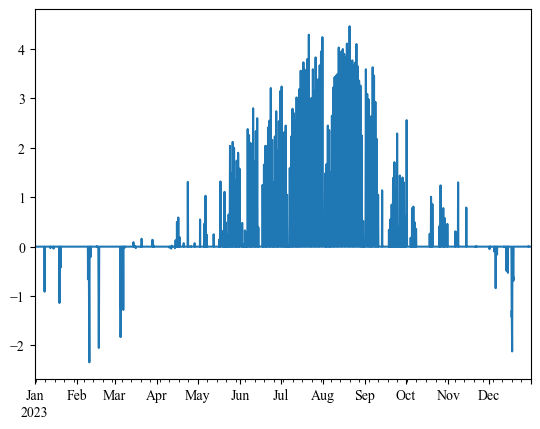

In [252]:
# Make new column for amount of excess degrees, 0 if within comfortable range.
excess_conditions = [living_df['in_range'] == 'Too Hot', living_df['in_range'] == 'Too Cold', living_df['in_range'] == 'In Range']
excess_choices = [living_df['cooling_deviation'], living_df['heating_deviation'], 0]
living_df['excess_temp'] = np.select(excess_conditions, excess_choices)

too_hot_df = living_df[living_df['in_range'] == 'Too Hot'] # If exceeds, cooling_deviation is magnitude
too_cold_df = living_df[living_df['in_range'] == 'Too Cold'] # If exceeds, heating_deviation is magnitude

living_df.excess_temp.plot()
plt.show()

In [253]:
living_df.head()

,living_space_temp,heating_setpoint,cooling_setpoint,outdoor_temp,heating_deviation,cooling_deviation,exceeds_setpoints,in_range,excess_temp
2023-01-01 00:00:00,72.0,72,74,42.98,0.0,-2.0,False,In Range,0.0
2023-01-01 01:00:00,72.0,72,74,44.06,0.0,-2.0,False,In Range,0.0
2023-01-01 02:00:00,72.0,72,74,44.96,0.0,-2.0,False,In Range,0.0
2023-01-01 03:00:00,72.0,72,74,46.04,0.0,-2.0,False,In Range,0.0
2023-01-01 04:00:00,72.0,72,74,46.94,0.0,-2.0,False,In Range,0.0


In [254]:
# Saving cleaned dataset
living_df.to_csv('atx_hourly_cleaned.csv')

In [255]:
import datetime as dt

# Condensing to day by day. Aggregating by excess minimum and maximum temperature.
living_dod_df = living_df.reset_index().rename(columns={'index': 'datetime'})
high_low_df = living_dod_df.groupby([living_dod_df['datetime'].dt.date]).agg({'excess_temp': [np.min, np.max]})

high_low_df['excess_high_low'] = high_low_df['excess_temp']['amin'] + high_low_df['excess_temp']['amax'] #TODO: doesn't account for edge case day exceeds both heating and cooling

# Aggregating the rest of the dataframe by mean temperature for that day and adding column.
living_dod_df = living_dod_df.groupby([living_dod_df['datetime'].dt.date]).mean()
living_dod_df['excess_high_low'] = high_low_df['excess_high_low']
living_dod_df


C:\Users\micha.DESKTOP-U2HVTMF\AppData\Local\Temp\ipykernel_7884\2050107287.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  living_dod_df = living_dod_df.groupby([living_dod_df['datetime'].dt.date]).mean()


,living_space_temp,heating_setpoint,cooling_setpoint,outdoor_temp,heating_deviation,cooling_deviation,exceeds_setpoints,excess_temp,excess_high_low
datetime,,,,,,,,,
2023-01-01,72.190417,72.0,74.0,49.0025,0.190417,-1.809583,0.000000,0.000000,0.00
2023-01-02,72.591667,72.0,74.0,51.6575,0.591667,-1.408333,0.000000,0.000000,0.00
2023-01-03,72.000000,72.0,74.0,41.2550,0.000000,-2.000000,0.000000,0.000000,0.00
2023-01-04,72.472500,72.0,74.0,45.8450,0.472500,-1.527500,0.000000,0.000000,0.00
2023-01-05,72.565417,72.0,74.0,49.1300,0.565417,-1.434583,0.000000,0.000000,0.00
...,...,...,...,...,...,...,...,...,...
2023-12-27,72.421250,72.0,74.0,45.0350,0.421250,-1.578750,0.000000,0.000000,0.00
2023-12-28,72.714167,72.0,74.0,55.5575,0.714167,-1.285833,0.000000,0.000000,0.00
2023-12-29,73.219583,72.0,74.0,68.0825,1.219583,-0.780417,0.000000,0.000000,0.00


In [256]:
excess_df = living_dod_df[living_dod_df['exceeds_setpoints'] != 0]
excess_df.head()

,living_space_temp,heating_setpoint,cooling_setpoint,outdoor_temp,heating_deviation,cooling_deviation,exceeds_setpoints,excess_temp,excess_high_low
datetime,,,,,,,,,
2023-01-08,71.870833,72.0,74.0,35.3375,-0.129167,-2.129167,0.333333,-0.129167,-0.91
2023-01-12,72.009583,72.0,74.0,46.6625,0.009583,-1.990417,0.041667,-0.001250,-0.03
2023-01-14,72.705000,72.0,74.0,53.9600,0.705000,-1.295000,0.041667,-0.001667,-0.04
2023-01-19,71.805000,72.0,74.0,38.3000,-0.195000,-2.195000,0.375000,-0.195000,-1.14
2023-01-20,71.956667,72.0,74.0,46.1150,-0.043333,-2.043333,0.208333,-0.043333,-0.42


## Calendar Heatmap Visualizations

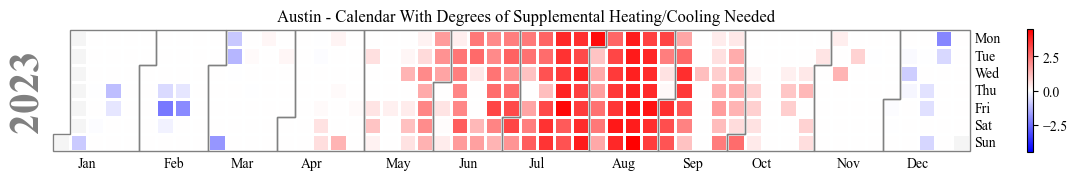

In [257]:
import calplot
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm, CenteredNorm

# Creating custom color map to place white at 0 value.
cmap_min = excess_df['excess_high_low'].min()
cmap_max = excess_df['excess_high_low'].max()
ts_norm = TwoSlopeNorm(vmin = cmap_min, vcenter = 0, vmax = cmap_max)


excess_df.index = pd.to_datetime(excess_df.index)

# Plotting excess days on calendar heatmap, centered norm.
calplot.calplot(excess_df['excess_high_low'],suptitle = 'Austin - Calendar With Degrees of Supplemental Heating/Cooling Needed',norm=CenteredNorm(),cmap = 'bwr')
plt.savefig('Viz_Outputs\\austin_cal_centered.pdf', bbox_inches='tight')

This is a realistic visualization: even though there are some days that do dip below the cooling threshold, they are so miniscule that it would likely not create a noticiable increase in temperature. To ensure that those visualizations show up, we can use a norm sloped around the center (0).

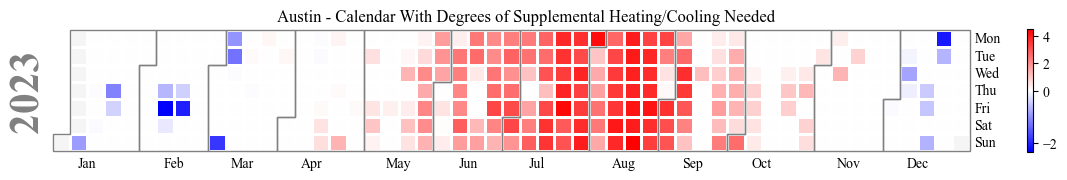

In [258]:
# Plotting excess days on calendar heatmap, two sloped norm.
calplot.calplot(excess_df['excess_high_low'],suptitle = 'Austin - Calendar With Degrees of Supplemental Heating/Cooling Needed',norm=ts_norm,vmin=cmap_min, vmax=cmap_max,cmap = 'bwr')
plt.savefig('Viz_Outputs\\austin_cal_tsnorm.pdf', bbox_inches='tight')

This has a slightly less intuitive legend since it is nonlinear but does ensure that both the coldest and hottest days show up.

This is an interesting visualization and it definitely helps create a sense of intuition on which days the home system would need additional cooling/heating. However, there is some information that it abstracts out, such as by how many degrees the home exceeds comfort levels, and how much energy the system is using. Because sensing temperature is very subjective, minute changes may not be sensible and may be even able to be abstracted out of the visualization if they are not extreme enough.

Referring back to knowing particularly how much hotter or colder the home is exceeding limits: we can add labels to the cells, but at the cost of visual clutter.

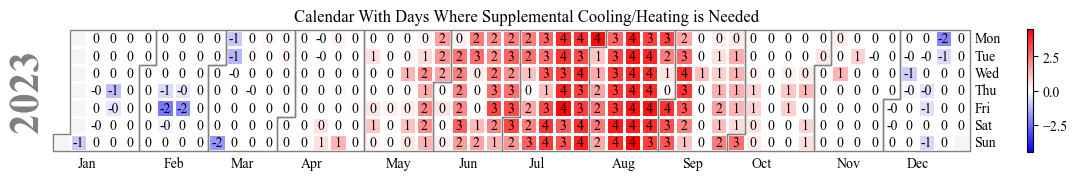

In [259]:
calplot.calplot(excess_df['excess_high_low'], suptitle = 'Calendar With Days Where Supplemental Cooling/Heating is Needed', norm=CenteredNorm(),cmap = 'bwr',
                textformat= '{:.0f}', textfiller = '', textcolor = 'black')
plt.savefig('Viz_Outputs\\austin_cal_centered_numbered.pdf', bbox_inches='tight')

This does add additional information, but because most of the temperature deviations are minute, the smaller details are not as pronounced in this plot. This does help add intuition that even on the hottest days, however, the home is not rising or falling more than 1-2 degrees the set levels of comfort, which may be assuring to homeowners and contractors that their system is properly sized.

C:\Users\micha.DESKTOP-U2HVTMF\AppData\Local\Temp\ipykernel_7884\17877191.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excess_df['excess_cubed'] = np.power(excess_df['excess_high_low'] * 100 , 3) #x100 to get every value above 1.


(<Figure size 1250x170 with 2 Axes>,
 array([<AxesSubplot: ylabel='2023'>], dtype=object))

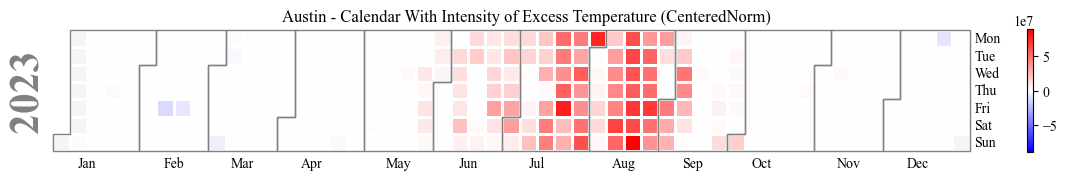

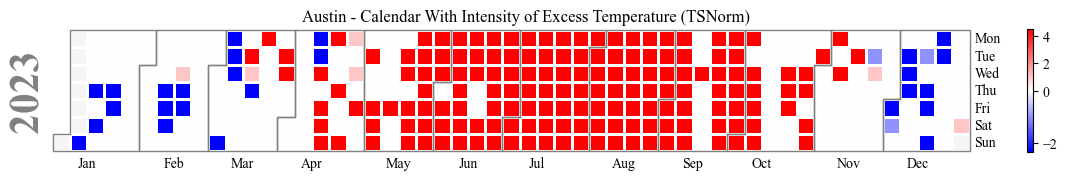

In [260]:
#TODO:
#Try different ranges for how bad it actually gets. squared/cubed of number of degrees out as heatmap value instead.

# Trying cubed value for intensity.
excess_df['excess_cubed'] = np.power(excess_df['excess_high_low'] * 100 , 3) #x100 to get every value above 1.
calplot.calplot(excess_df['excess_cubed'],suptitle = 'Austin - Calendar With Intensity of Excess Temperature (CenteredNorm)',norm=CenteredNorm(),cmap = 'bwr')
calplot.calplot(excess_df['excess_cubed'],suptitle = 'Austin - Calendar With Intensity of Excess Temperature (TSNorm)',norm=ts_norm,cmap = 'bwr')

Interesting to explore the intensity by cubing the values. It does help focus in on only the worst days in the centered norm plot, but both plots still abstract the true value of the temperature difference. The TSNorm is argubly worse because it only intensifies both sides, but it may have its uses.

## Timeseries Visualizations

This section includes the day-by-day indoor and outdoor temperature plots

In [261]:
# Time Series Plotting Function

def plot_ts(df, plt_title="Indoor Temperature Over Time", plt_ylabel = "Indoor Temperature", plt_xlabel = "Time", fill = False, save=False):
    living_temp = df['living_space_temp']
    heating_set = df['heating_setpoint']
    cooling_set = df['cooling_setpoint']
    #outdoor_temp = df['outdoor_temp']

    living_temp.plot(label = "Indoor Temperature", zorder=10, color='black')
    heating_set.plot(label="Heating Setpoint", color='blue')
    cooling_set.plot(label="Cooling Setpoint", color='red')
    #outdoor_temp.plot(label="Cooling Setpoint", color='green')

    # Adding fill Option
    if fill:
        plt.fill_between(df.index, living_temp, cooling_set, where=living_temp>=cooling_set, color='pink', label="Additional Cooling Needed")

        # Doing the same for where temp is lower than heating set
        plt.fill_between(df.index, living_temp, heating_set, where=living_temp<=heating_set, color='lightblue', label="Additional Heating Needed")

    plt.ylabel(plt_ylabel)
    plt.xlabel("Time")
    
    ax = plt.gca()
    ax.set_ylim([68, 80])
    
    plt.title(plt_title)
    plt.legend()

    if save:
        plt.savefig(f'Viz_Outputs\\{plt_title}.pdf', bbox_inches='tight')
        
    plt.show()


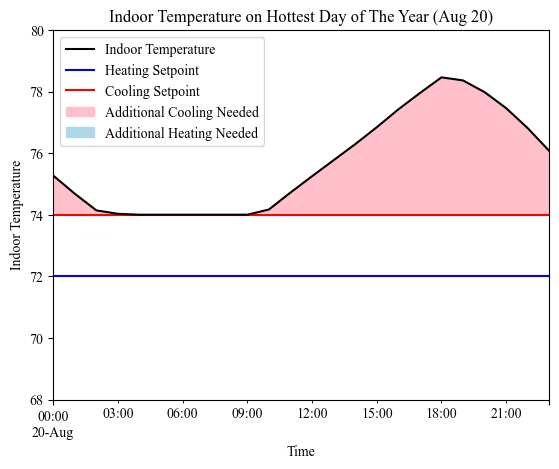

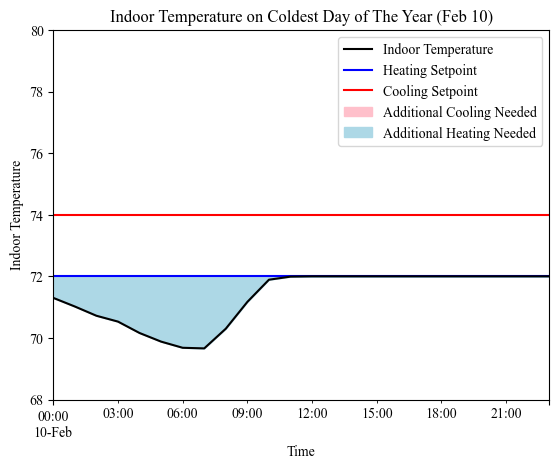

In [262]:
#Plotting Hottest Day
hottest_day = living_dod_df['excess_high_low'].idxmax()
hottest_day_hourly = living_df[living_df.index.date == hottest_day] 

plot_ts(hottest_day_hourly, plt_title='Indoor Temperature on Hottest Day of The Year (Aug 20)', fill=True, save=True) #TODO: consider editing these to specific dates.

#Plotting Coldest Day
coldest_day = living_dod_df['excess_high_low'].idxmin()
coldest_day_hourly = living_df[living_df.index.date == coldest_day] 

plot_ts(coldest_day_hourly, plt_title='Indoor Temperature on Coldest Day of The Year (Feb 10)', fill=True, save=True)

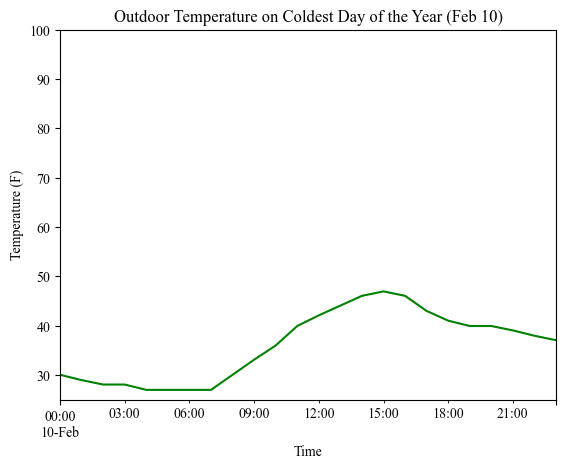

In [263]:
coldest_day
coldest_day_hourly.outdoor_temp.plot(color="green")
plt.title("Outdoor Temperature on Coldest Day of the Year (Feb 10)")
plt.ylabel("Temperature (F)")
plt.xlabel("Time")
ax = plt.gca()
ax.set_ylim([25, 100])
plt.savefig(f'Viz_Outputs\\Outdoor Temperature on Coldest Day of the Year.pdf', bbox_inches='tight')
plt.show()

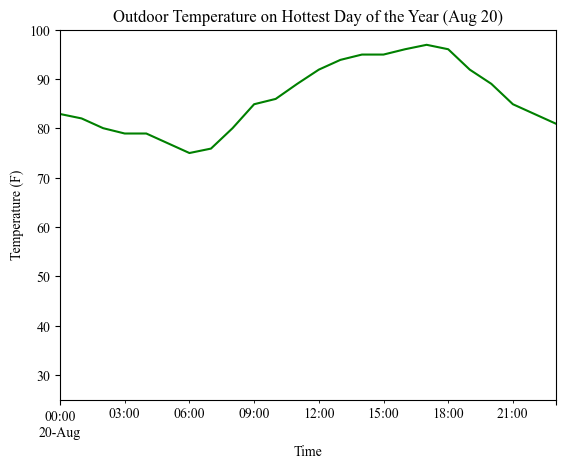

In [264]:
hottest_day_hourly.outdoor_temp.plot(color="green")
plt.title("Outdoor Temperature on Hottest Day of the Year (Aug 20)")
plt.ylabel("Temperature (F)")
plt.xlabel("Time")
ax = plt.gca()
ax.set_ylim([25, 100])
plt.savefig(f'Viz_Outputs\\Outdoor Temperature on Hottest Day of the Year.pdf', bbox_inches='tight')
plt.show()

It can be seen quite clearly how the temperature on the hottest day of the year leads to the indoor temperature exceeding the thermostat set temperatures, which may lead to discomfort. However, even on the coldest day of the year, the temperature barely dips below the setting, meaning that the heating system is likely properly sized or even oversized.

C:\Users\micha.DESKTOP-U2HVTMF\AppData\Local\Temp\ipykernel_7884\2144147772.py:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  spring_day_hourly = living_df[living_df.index.date == spring_day]
C:\Users\micha.DESKTOP-U2HVTMF\AppData\Local\Temp\ipykernel_7884\2144147772.py:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  fall_day_hourly = living_df[living_df.index.date == fall_day]


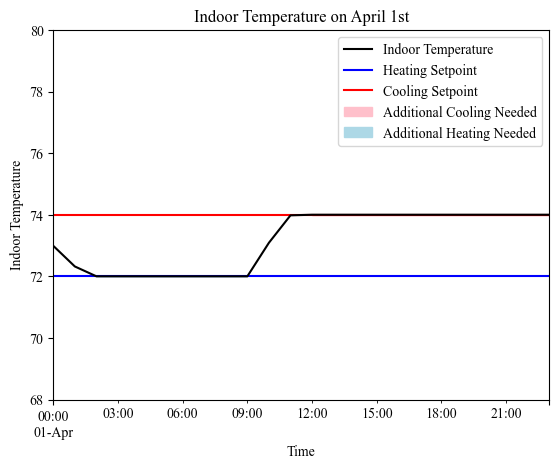

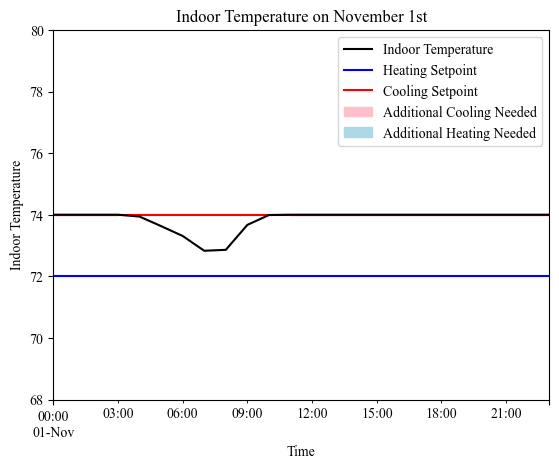

In [265]:
# TODO: Perhaps get a house with both slightly undersized heating/cooling to highlight both cold and hot days.

# Charting normal days, April 1st and November 1st.
spring_day = pd.to_datetime('2023-04-01', format='%Y-%m-%d')
fall_day = pd.to_datetime('2023-11-01', format='%Y-%m-%d')

spring_day_hourly = living_df[living_df.index.date == spring_day] 
fall_day_hourly = living_df[living_df.index.date == fall_day] 

plot_ts(spring_day_hourly, plt_title='Indoor Temperature on April 1st', fill=True, save=True)
plot_ts(fall_day_hourly, plt_title='Indoor Temperature on November 1st', fill=True, save=True)

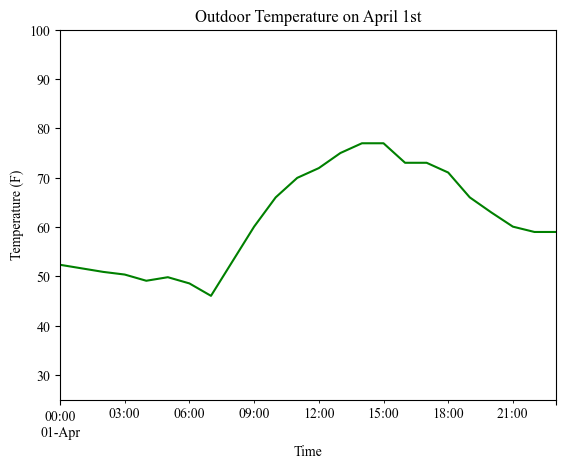

In [266]:
spring_day_hourly.outdoor_temp.plot(color="green")
plt.title("Outdoor Temperature on April 1st")
plt.ylabel("Temperature (F)")
plt.xlabel("Time")
ax = plt.gca()
ax.set_ylim([25, 100])
plt.savefig(f'Viz_Outputs\\Outdoor Temperature on April 1st.pdf', bbox_inches='tight')
plt.show()

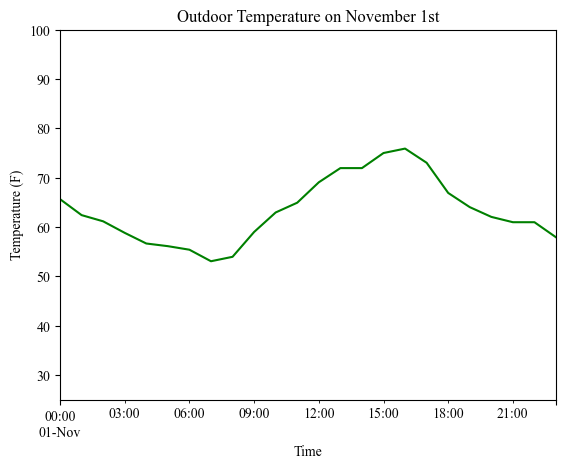

In [267]:
fall_day_hourly.outdoor_temp.plot(color="green")
plt.title("Outdoor Temperature on November 1st")
plt.ylabel("Temperature (F)")
plt.xlabel("Time")
ax = plt.gca()
ax.set_ylim([25, 100])
plt.savefig(f'Viz_Outputs\\Outdoor Temperature on November 1st.pdf', bbox_inches='tight')
plt.show()

Generating outdoor temp plots to display alongside

In this instance, although the indoor temperature does shift throughout the day, it remains within the thermostat set bounds.

In [268]:
#TODO: Visualize both calendar and day sample plots together. Try GridSpec, may be more efficient to just export files and arrange manually.

#TODO: Tell story using the rest of the hourly data: i.e. Hourly Weather/Outdoor Temperature  ->  Energy Usage -> Indoor Temperature
# Show groups of three for all types of days or just zoom in on the hottest day? Can see how it looks in the poster.

In [269]:
# Creating new df with outdoor temperature and energy usage.

outdoor_energy_cols = ['My Design - Energy Use| Total', 'My Design - Load| Heating: Delivered', 'My Design - Load| Heating: Delivered', 'My Design - Weather| Drybulb Temperature']
short_energy_labels = ["energy_use", "heating_delivered", "cooling_delivered", "outdoor_temp"]

# Creating date range
date_range = pd.date_range(start="2023-01-01", end="2024-01-01", freq="1H", inclusive="left")

energy_outdoor_df = (atx_df[outdoor_energy_cols].set_axis(short_energy_labels, axis=1) # slicing and renaming columns
                                                .set_index(date_range))                # changing to hourly index
            
assert energy_outdoor_df.shape[0] == 365*24
energy_outdoor_df.head()


,energy_use,heating_delivered,cooling_delivered,outdoor_temp
2023-01-01 00:00:00,4.12,8.07,8.07,42.98
2023-01-01 01:00:00,4.15,8.69,8.69,44.06
2023-01-01 02:00:00,4.18,9.08,9.08,44.96
2023-01-01 03:00:00,5.61,9.25,9.25,46.04
2023-01-01 04:00:00,4.22,9.27,9.27,46.94


In [270]:
# Adding in indoor temperature and temperature setpoints
energy_outdoor_df['indoor_temp'] = living_df['living_space_temp']
energy_outdoor_df['heating_setpoint'] = living_df['heating_setpoint']
energy_outdoor_df['cooling_setpoint'] = living_df['cooling_setpoint']
energy_outdoor_df

,energy_use,heating_delivered,cooling_delivered,outdoor_temp,indoor_temp,heating_setpoint,cooling_setpoint
2023-01-01 00:00:00,4.12,8.07,8.07,42.98,72.0,72,74
2023-01-01 01:00:00,4.15,8.69,8.69,44.06,72.0,72,74
2023-01-01 02:00:00,4.18,9.08,9.08,44.96,72.0,72,74
2023-01-01 03:00:00,5.61,9.25,9.25,46.04,72.0,72,74
2023-01-01 04:00:00,4.22,9.27,9.27,46.94,72.0,72,74
...,...,...,...,...,...,...,...
2023-12-31 19:00:00,6.98,0.00,0.00,69.08,74.0,72,74
2023-12-31 20:00:00,6.56,0.00,0.00,68.00,74.0,72,74
2023-12-31 21:00:00,5.70,0.00,0.00,68.00,74.0,72,74
2023-12-31 22:00:00,4.51,0.00,0.00,68.00,74.0,72,74


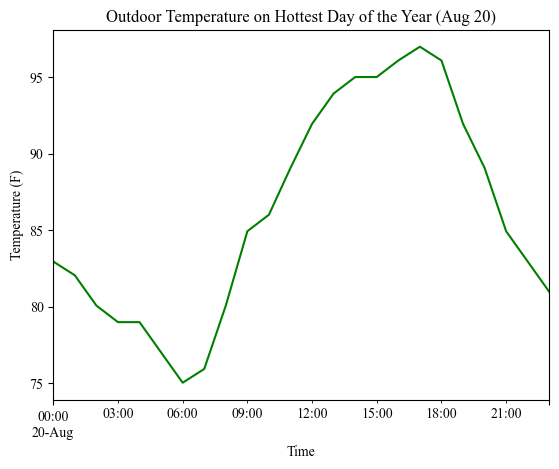

In [271]:
# For the hottest day: plotting outdoor temperature, energy usage, and indoor temperature with setpoints 
energy_outdoor_hottest = energy_outdoor_df[energy_outdoor_df.index.date == hottest_day]
energy_outdoor_hottest.outdoor_temp.plot(color="green")
plt.title("Outdoor Temperature on Hottest Day of the Year (Aug 20)")
plt.ylabel("Temperature (F)")
plt.xlabel("Time")
plt.savefig(f'Viz_Outputs\\Outdoor Temperature on Hottest Day of the Year.pdf', bbox_inches='tight')
plt.show()


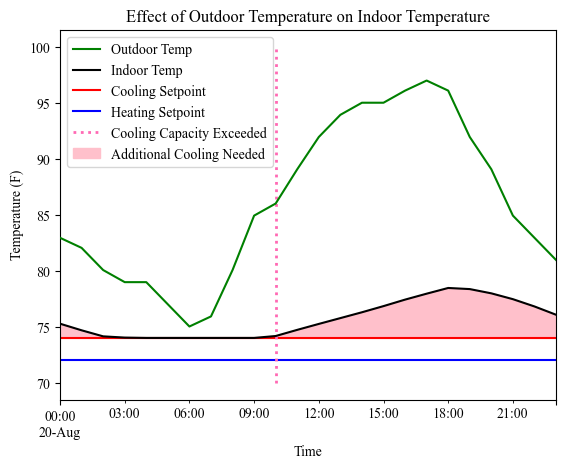

In [272]:
# All together

energy_outdoor_hottest.outdoor_temp.plot(color="green", label="Outdoor Temp", zorder=5)
energy_outdoor_hottest.indoor_temp.plot(color="black", label="Indoor Temp", zorder=10)
energy_outdoor_hottest.cooling_setpoint.plot(color="red", label="Cooling Setpoint")
energy_outdoor_hottest.heating_setpoint.plot(color="blue", label="Heating Setpoint")

# single vline with full ymin and ymax
plt.vlines(x=pd.to_datetime('2023-08-20 10:00:00'), ymin=70, ymax=100, colors='hotpink', ls=':', lw=2, label='Cooling Capacity Exceeded')
plt.fill_between(energy_outdoor_hottest.index, energy_outdoor_hottest.indoor_temp, energy_outdoor_hottest.cooling_setpoint, where=energy_outdoor_hottest.indoor_temp>=energy_outdoor_hottest.cooling_setpoint, color='pink', label="Additional Cooling Needed")
plt.ylabel("Temperature (F)")
plt.xlabel("Time")

plt.legend()

plt.title("Effect of Outdoor Temperature on Indoor Temperature")
plt.savefig(f'Viz_Outputs\\Effect of Outdoor Temperature on Energy Usage and Indoor Temperature.pdf', bbox_inches='tight')
plt.show()

